In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
#%load_ext autoreload
#%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [3]:
n_steps=100
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
H = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

Had3=np.kron(H, np.kron(H,H))

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)
#Matrix(Had3)

Matrix([
[1.0,                    0,                    0,                    0,                    0,                    0,                    0,   0],
[  0,      1.0 + 0.00103*I,   9.9e-5 + 0.00103*I,                    0, -9.58e-5 - 0.00206*I,                    0,                    0,   0],
[  0, -9.58e-5 + 0.00103*I,      1.0 - 0.00206*I,                    0,   9.9e-5 + 0.00103*I,                    0,                    0,   0],
[  0,                    0,                    0,      1.0 + 0.00103*I,                    0, -9.58e-5 + 0.00103*I,   9.9e-5 - 0.00206*I,   0],
[  0,   9.9e-5 - 0.00206*I, -9.58e-5 + 0.00103*I,                    0,      1.0 + 0.00103*I,                    0,                    0,   0],
[  0,                    0,                    0,   9.9e-5 + 0.00103*I,                    0,      1.0 - 0.00206*I, -9.58e-5 + 0.00103*I,   0],
[  0,                    0,                    0, -9.58e-5 - 0.00206*I,                    0,   9.9e-5 + 0.00103*I,      1.0 + 

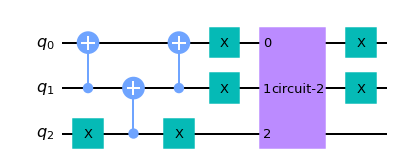

In [4]:
qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.append(Toffoli_gate,[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

In [5]:
B=matrix_from_circuit(B_qc)
B

Matrix([
[                                            0,                6.5522583e-33 + 7.7273371e-33*I,                1.9300264e-33 + 5.1745489e-33*I, -1.00875766104946e-16 + 1.00484651424462e-16*I,                   1.0 + 1.51722884638629e-15*I, -2.34326020266314e-17 - 5.65713056143851e-17*I, -2.34326020266314e-17 - 5.65713056143851e-17*I,              -2.6512258e-33 + 2.6512258e-33*I],
[-2.34326020266314e-17 - 5.6571305614385e-17*I,                                 -3.7493995e-33,                   1.0 + 1.18416193899875e-15*I,   2.34326020266316e-17 - 5.6571305614385e-17*I,               6.0365731e-33 - 1.11995796e-32*I,  5.61334797634313e-17 - 3.35311227409845e-17*I,                                              0,             -2.3183583e-33 - 1.22569791e-32*I],
[-2.34326020266314e-17 - 5.6571305614385e-17*I,                   1.0 + 1.20042077876291e-15*I,                                 -3.7493995e-33,   2.34326020266316e-17 - 5.6571305614385e-17*I,               8.2155141e-33 - 1

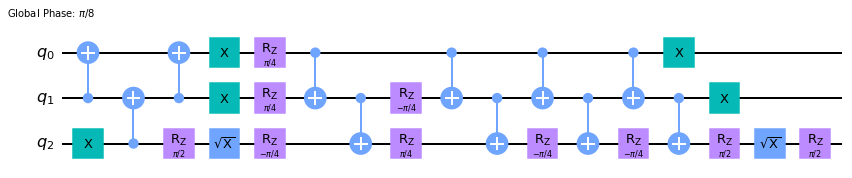

In [6]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

In [7]:
#for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
#
#    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix_(2*time/n_steps)).evalf(precision)


M_N = B*trotterized*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[        1.0 + 0.0010323*I,   -9.5814e-5 + 0.0010323*I,    9.902e-5 - 0.0020645*I,  5.8472e-20 - 2.4007e-20*I],
[   9.902e-5 + 0.0010323*I,          1.0 - 0.0020645*I,  -9.5814e-5 + 0.0010323*I,   5.6076e-20 - 2.979e-20*I],
[ -9.5814e-5 - 0.0020645*I,     9.902e-5 + 0.0010323*I,         1.0 + 0.0010323*I, -1.1455e-19 + 5.3798e-20*I],
[-5.8321e-20 - 2.437e-20*I, -5.6151e-20 - 2.9609e-20*I, 1.1447e-19 + 5.3979e-20*I,         1.0 - 7.3781e-16*I]])

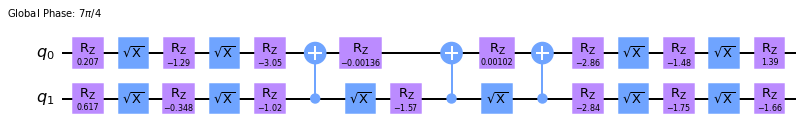

In [8]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

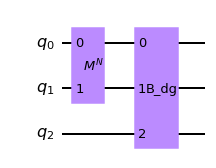

In [9]:
initial_state="000"

qr_U = QuantumRegister(3, name="q")
qc_U = QuantumCircuit(qr_U, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc_U.x(qr_U[k])
    l+=1

### appending the evolution

qc_U.append(M_N_qc,[qr_U[0],qr_U[1]])
qc_U.append(B_qc.inverse(),[qr_U[0],qr_U[1],qr_U[2]])

qc_U.draw(output="mpl")

In [10]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[ 2.55065461985039e-16 + 7.09187451879363e-17*I, -2.07621763570624e-15 + 1.18701278016896e-15*I, -2.18974349303889e-14 + 1.64391188128022e-13*I,                  1.0 + 5.39596145543442e-13*I,             -3.69778549e-32 - 3.04217103e-32*I,             1.479114197e-31 + 9.86645918e-32*I,                            -7.9099922833e-30*I, -1.11022302462516e-16 - 1.11022302462546e-16*I],
[   -9.5813777963527e-5 - 0.00206452934039347*I,    9.90199867683457e-5 + 0.00103226467019728*I,       0.999996793791193 + 0.0010322646696502*I, 2.16569344509712e-14 + 1.64301087714129e-13*I,  -2.3635607360184e-17 + 5.68236967545464e-17*I,  5.42101086242752e-20 - 2.79639348175522e-19*I, -2.22044604925031e-16 - 5.71242198456859e-20*I,         6.3108872418e-30 - 6.08098418252e-29*I],
[   9.90199867463997e-5 + 0.00103226467036381*I,      0.999996793791194 - 0.00206452933985227*I,    -9.5813777961118e-5 + 0.00103226467019735*I, 1.84838711289462e-15 + 1.25404477771264e-15*I, -2.34187669256869e-17 + 5.636

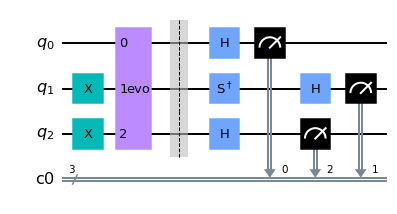

In [11]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [12]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [13]:
cal_circ[0].draw()

░ ┌─┐      
q94_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q94_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q94_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2

In [14]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [15]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.x(qr_cal_id)
    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
        else:
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [16]:
calib_circuits_identity[1].draw()

┌───┐┌──────┐     ┌─┐      
q98_0: ┤ X ├┤0     ├─────┤M├──────
       ├───┤│      │┌───┐└╥┘┌─┐   
q98_1: ┤ X ├┤1 evo ├┤ X ├─╫─┤M├───
       ├───┤│      │├───┤ ║ └╥┘┌─┐
q98_2: ┤ X ├┤2     ├┤ X ├─╫──╫─┤M├
       └───┘└──────┘└───┘ ║  ║ └╥┘
 c5: 3/═══════════════════╩══╩══╩═
                          0  1  2

In [17]:
calib_circuits_itself[1].draw()

┌───┐┌──────┐┌─┐      
q97_0: ┤ X ├┤0     ├┤M├──────
       └───┘│      │└╥┘┌─┐   
q97_1: ─────┤1 evo ├─╫─┤M├───
            │      │ ║ └╥┘┌─┐
q97_2: ─────┤2     ├─╫──╫─┤M├
            └──────┘ ║  ║ └╥┘
 c4: 3/══════════════╩══╩══╩═
                     0  1  2

In [18]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [19]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [20]:
Matrix(meas_fitter_qiskit.cal_matrix)

Matrix([
[0.93453125,   0.061125, 0.02559375, 0.00159375,  0.0391875, 0.00253125,   0.001125,   9.375e-5],
[ 0.0316875, 0.90234375, 0.00103125, 0.02421875,  0.0013125, 0.03859375,   9.375e-5,   0.001125],
[0.01121875,    0.00075,   0.915375,   0.056125, 0.00053125,    6.25e-5,  0.0380625,   0.002125],
[  0.000375, 0.01096875, 0.03221875, 0.89240625,          0, 0.00046875,     0.0015, 0.03853125],
[0.02115625, 0.00165625,   0.000625,          0, 0.91584375,  0.0569375,  0.0245625, 0.00159375],
[ 0.0006875,  0.0229375,          0, 0.00078125,   0.032625, 0.88996875, 0.00065625, 0.02384375],
[0.00034375,          0,      0.024, 0.00134375, 0.01028125,   0.000625, 0.90215625, 0.05665625],
[         0, 0.00021875, 0.00115625, 0.02353125, 0.00021875,  0.0108125, 0.03184375, 0.87603125]])

In [21]:
Matrix(meas_fitter_our_identity.cal_matrix)

Matrix([
[0.88184375,       0.07, 0.03840625, 0.00921875,  0.0435625,   0.003875,     0.0025,     0.0105],
[ 0.0461875,  0.8558125, 0.00665625,   0.038375,  0.0034375,  0.0411875,  0.0096875,  0.0021875],
[ 0.0248125,    0.00675,   0.868875,   0.068375, 0.00203125,  0.0089375, 0.04378125, 0.00571875],
[0.00596875, 0.02503125,   0.045375,   0.841875, 0.00921875,  0.0013125, 0.00340625, 0.04284375],
[   0.02775,   0.003625, 0.00190625,   0.011125, 0.86478125, 0.06846875, 0.03634375,    0.00825],
[0.00240625,   0.028125,  0.0091875, 0.00128125, 0.04484375,     0.8465, 0.00684375, 0.03671875],
[0.00140625, 0.00978125, 0.02690625,   0.003125, 0.02528125, 0.00628125,  0.8536875,  0.0653125],
[  0.009625,   0.000875,  0.0026875,   0.026625, 0.00684375,  0.0234375,    0.04375, 0.82846875]])

In [22]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [23]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [24]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q1398_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q1398_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q1398_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c18: 3/══════╩════════════════╩══╩═
               1                0  2

In [25]:
meas_fitter_qiskit.cal_matrix

array([[9.3453125e-01, 6.1125000e-02, 2.5593750e-02, 1.5937500e-03,
        3.9187500e-02, 2.5312500e-03, 1.1250000e-03, 9.3750000e-05],
       [3.1687500e-02, 9.0234375e-01, 1.0312500e-03, 2.4218750e-02,
        1.3125000e-03, 3.8593750e-02, 9.3750000e-05, 1.1250000e-03],
       [1.1218750e-02, 7.5000000e-04, 9.1537500e-01, 5.6125000e-02,
        5.3125000e-04, 6.2500000e-05, 3.8062500e-02, 2.1250000e-03],
       [3.7500000e-04, 1.0968750e-02, 3.2218750e-02, 8.9240625e-01,
        0.0000000e+00, 4.6875000e-04, 1.5000000e-03, 3.8531250e-02],
       [2.1156250e-02, 1.6562500e-03, 6.2500000e-04, 0.0000000e+00,
        9.1584375e-01, 5.6937500e-02, 2.4562500e-02, 1.5937500e-03],
       [6.8750000e-04, 2.2937500e-02, 0.0000000e+00, 7.8125000e-04,
        3.2625000e-02, 8.8996875e-01, 6.5625000e-04, 2.3843750e-02],
       [3.4375000e-04, 0.0000000e+00, 2.4000000e-02, 1.3437500e-03,
        1.0281250e-02, 6.2500000e-04, 9.0215625e-01, 5.6656250e-02],
       [0.0000000e+00, 2.1875000e-04, 1.1

In [26]:
'''
C_matrices_itself = []
C_matrices_identity = []

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

C_itself = np.matmul(U_tilde_itself, )
'''

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

U_ideal_abs = np.abs(U_ideal)**2
#print(type(U_ideal_abs))
#U_ideal_abs = np.asarray(Matrix(U_ideal_abs).n(10, chop=True), dtype='float64')
#print(type(U_ideal_abs))
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity

for base in qcs_basis:
    
    '''
    base.remove_final_measurements()

    base_matrix = matrix_from_cirquit(base, type="numpy")
    base_matrix_H = np.linalg.inv(base_matrix)

    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_itself, U_ideal_inv,  base_matrix_H])
    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, U_ideal_inv,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))
    '''

    base.remove_final_measurements()

    base_matrix_amplitudes = matrix_from_cirquit(base, type="numpy")
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    #C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_inverse])
    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_inverse])
    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  np.transpose(base_matrix)])
    

    C_aus_identity = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_identity,  base_matrix_inverse])
    #C_aus_identity = np.linalg.multi_dot([base_matrix, C_identity, base_matrix_inverse])


    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

NameError: name 'C_matrices_identity' is not defined

In [ ]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [ ]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [ ]:
raw_res.get_counts(-1)

{'010': 1193,
 '000': 125,
 '110': 26572,
 '100': 1039,
 '001': 345,
 '011': 556,
 '111': 1605,
 '101': 565}

In [ ]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [ ]:
qiskit_res.get_counts(-1)

{'000': 60.90730482135207,
 '001': 332.5450476679499,
 '010': 8.565005328132197e-13,
 '011': 540.8811122528482,
 '100': 313.0089347047067,
 '101': 571.5264146887895,
 '110': 29494.647720584468,
 '111': 686.4834652798897}

In [ ]:
It_comp=occurrences_to_vector(itself_res.get_counts(-1))/(shots)
It_H=np.dot(Had3,It_comp)
Matrix(It_H)

Matrix([
[ 0.353553390593274],
[ 0.352329879794656],
[-0.353144289742896],
[-0.352738980645033],
[-0.353144289742896],
[-0.352738980645033],
[ 0.353553390593274],
[ 0.352329879794656]])

In [ ]:
itself_res.get_counts(0)

{'000': 3999.8772901565903,
 '001': 4000.100349000079,
 '010': 3999.8833282512574,
 '011': 3999.916739713325,
 '100': 3999.9259609089286,
 '101': 4000.001449130673,
 '110': 4000.142930433648,
 '111': 4000.151952405501}

In [ ]:
itself_res.get_counts(-1)

{'000': 4.0181820050323084e-12,
 '001': 18.513791071429225,
 '010': 1.1059110303614231e-13,
 '011': 1.0140718554241627e-12,
 '100': 1.3808759967447985e-12,
 '101': 2.4819907083727218e-12,
 '110': 31944.630221916304,
 '111': 36.85598701227716}

In [ ]:
identity_res.get_counts(-1)

{'000': 1.9012290083090187e-09,
 '001': 1.4663343852654392e-09,
 '010': 3.161672181058843e-09,
 '011': 408.2858463637789,
 '100': 2.7370201422968377e-09,
 '101': 297.2064858040453,
 '110': 31021.13694402774,
 '111': 273.37072381169514}

In [ ]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.82975334, 0.92077745, 0.96629744, 0.99313773])

In [ ]:
occurrences_to_vector(identity_res.get_counts(-1))

# Confronto caso ideale

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [ ]:
initial_state = One^One^Zero

#((initial_state @ U_heis3(float(time)) @ initial_state).eval())**2
np.abs((~initial_state @ U_heis3(float(time)) @ initial_state).eval())**2
